In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from PIL import Image, ImageDraw
from IPython.display import display
import cv2
import os

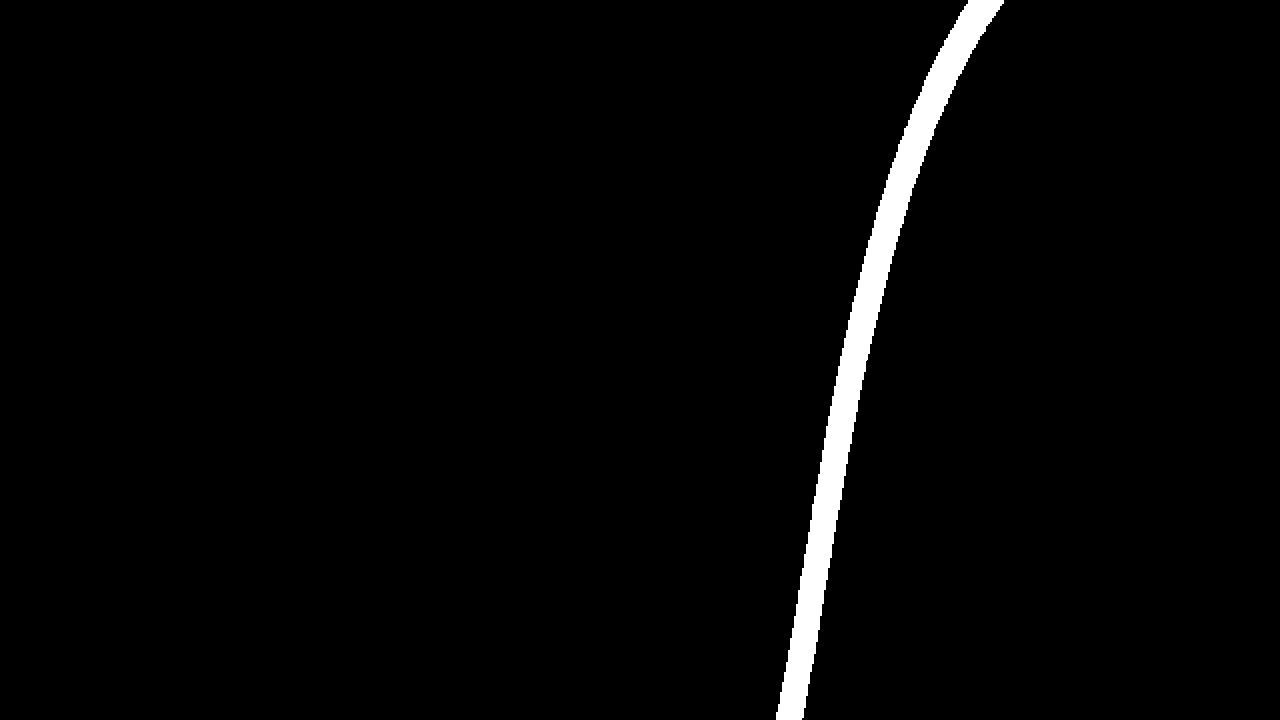

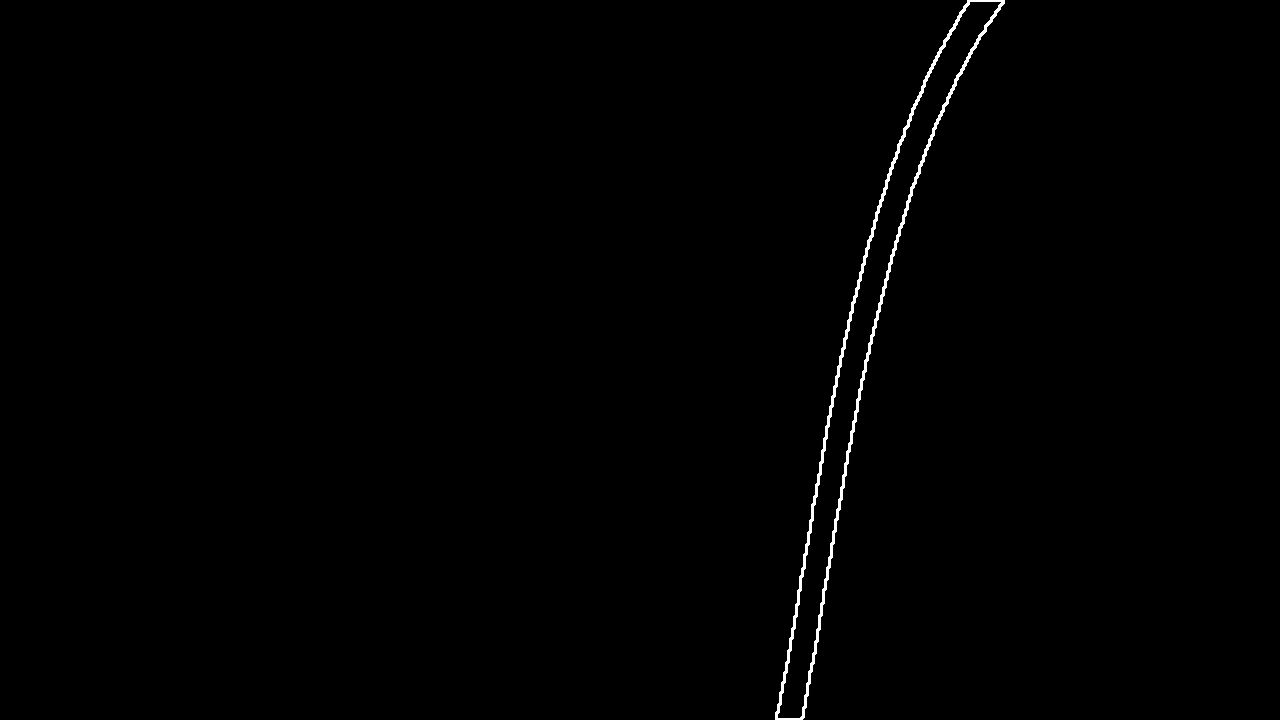

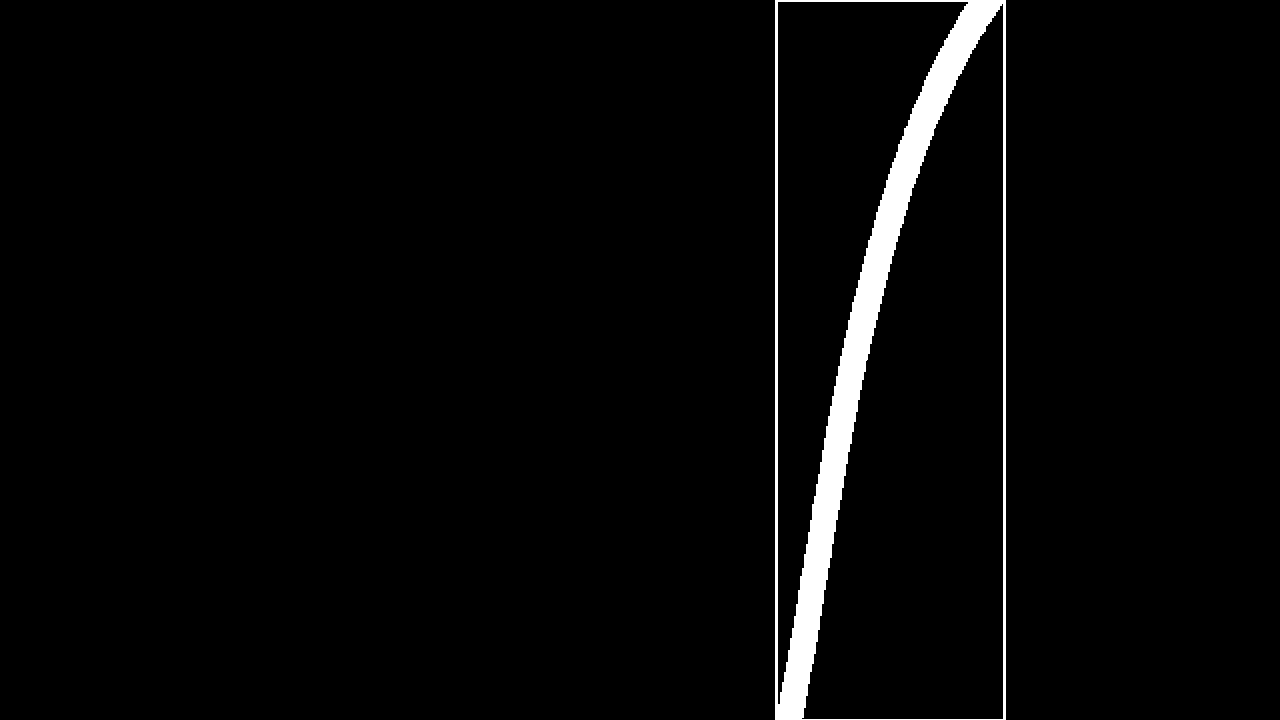

In [3]:
def process_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Image processing
    _, binary_mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    objects_info = []

    contour_image = np.zeros_like(mask)
    bounding_rect_image = mask.copy()
    yolo_bbox_image = mask.copy()
    
    for contour in contours:
        x, y, width, height = cv2.boundingRect(contour)
        class_label = 0 
        x_center, y_center, normalized_width, normalized_height = convert_coordinates_to_yolo(mask.shape[1], mask.shape[0], x, y, width, height)
        objects_info.append((class_label, x_center, y_center, normalized_width, normalized_height))
        
        cv2.rectangle(bounding_rect_image, (x, y), (x + width, y + height), 255, thickness=2)

        cv2.drawContours(contour_image, [contour], 0, 255, thickness=2)

    display(Image.fromarray(mask)) #display mask
    display(Image.fromarray(contour_image))# display contours
    display(Image.fromarray(bounding_rect_image)) #display rectangle

    return objects_info

def convert_coordinates_to_yolo(image_width, image_height, x, y, width, height):
    x_center = (x + width / 2) / image_width
    y_center = (y + height / 2) / image_height
    normalized_width = width / image_width
    normalized_height = height / image_height

    return x_center, y_center, normalized_width, normalized_height

def write_yolo_annotations(output_path, image_name, objects_info):
    annotation_file_path = os.path.join(output_path, image_name)

    with open(annotation_file_path, "w") as file:
        for obj_info in objects_info:
            line = f"{obj_info[0]} {obj_info[1]} {obj_info[2]} {obj_info[3]} {obj_info[4]}\n"
            file.write(line)


input_path = "/kaggle/input/electric-wires-image-segmentation/train/train/masks"
output_path = "/kaggle/working/labels"

# Create output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Trying it on one mask
mask_path = '/kaggle/input/electric-wires-image-segmentation/train/train/masks/0.png'
image_name = os.path.basename(mask_path).replace(".png", ".txt")

objects_info = process_mask(mask_path)
write_yolo_annotations(output_path, image_name, objects_info)
# Process each mask in the kaggle input directory
#for mask_name in os.listdir(input_path):
   # if mask_name.endswith(".png"):
    #    mask_path = os.path.join(input_path, mask_name)
     #   objects_info = process_mask(mask_path)
      #  write_yolo_annotations(output_path, mask_name, objects_info)

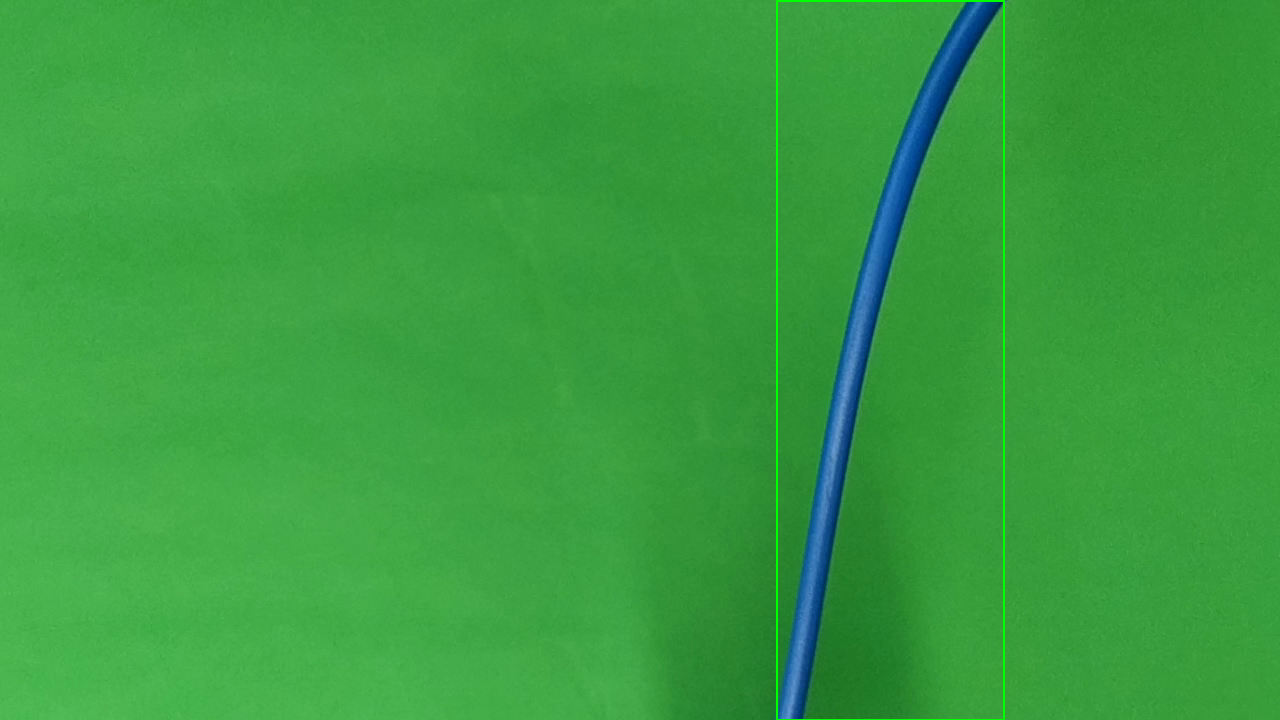

In [4]:
def read_yolo_annotations(annotation_path):
    with open(annotation_path, "r") as file:
        lines = file.readlines()
        objects_info = [list(map(float, line.strip().split())) for line in lines]
    return objects_info

def preprocess_for_yolo(image_path, annotation_path):
    image = Image.open(image_path)
    width, height = image.size
    draw = ImageDraw.Draw(image)
    objects_info = read_yolo_annotations(annotation_path)

    for obj_info in objects_info:
        label, x_center, y_center, normalized_width, normalized_height = obj_info

        # Convert YOLO coordinates to pixel coordinates
        x, y, w, h = int((x_center - normalized_width / 2) * width), int((y_center - normalized_height / 2) * height), int(normalized_width * width), int(normalized_height * height)

        # Draw rectangle on the image
        draw.rectangle([x, y, x + w, y + h], outline=(0, 255, 0), width=2)

    display(image)

image_path = '/kaggle/input/electric-wires-image-segmentation/train/train/imgs/0.png'
annotation_path = '/kaggle/working/labels/0.txt'

preprocess_for_yolo(image_path, annotation_path)